# Modules

In [49]:
import timm
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import matplotlib.pyplot as plt
from IPython.display import Image
os.environ["TORCH_HOME"] = "/media/hdd/Datasets/"
os.environ["FASTAI_HOME"] = "/media/hdd/Datasets/"

# Train

In [2]:
root_dir = "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/"
path = Path(root_dir)
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dls = fields.dataloaders(path)
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate]).to_fp16()
learn.fine_tune(1)

/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.790172,0.395765,0.858611,0.141389,04:00


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.332395,0.177464,0.930278,0.069722,00:54


In [3]:
learn.save("fish_v1_no_aug")

Path('models/fish_v1_no_aug.pth')

# GradCAM

In [63]:
class Hook:
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)

    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [64]:
class HookBwd:
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)

    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.hook.remove()

In [65]:
dls.valid_ds[1]

(PILImage mode=RGB size=590x445, TensorCategory(6))

In [66]:
learn.predict(dls.valid_ds[1][0])

('Red Mullet',
 TensorBase(6),
 TensorBase([3.3980e-07, 9.5405e-07, 2.6159e-06, 3.6172e-07, 3.4578e-08,
             1.6904e-07, 9.9963e-01, 1.4876e-06, 1.1928e-07, 1.2044e-06,
             1.6739e-07, 8.7124e-06, 1.2791e-06, 4.2001e-07, 3.5006e-04,
             2.5059e-06, 7.7516e-07, 2.5326e-07]))

In [99]:
learn.model[-2][4][-1]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

index 3 is out of range
index 4 is out of range
index 5 is out of range
index 6 is out of range
index 7 is out of range


<Figure size 1600x800 with 0 Axes>

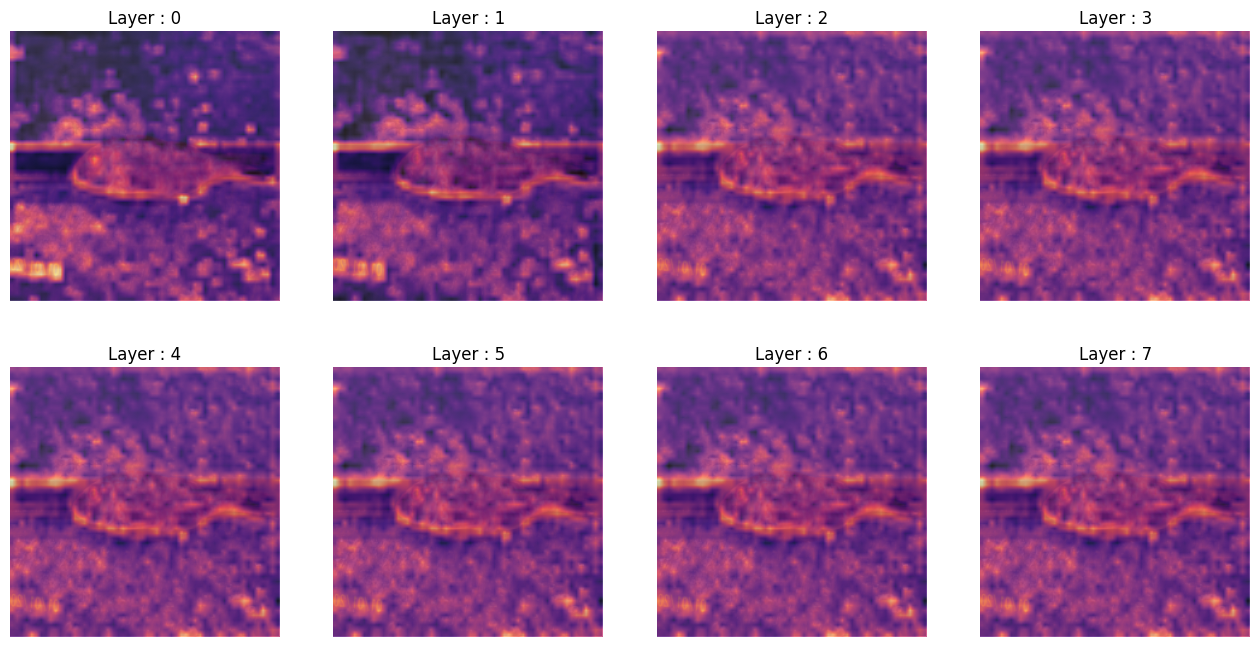

In [102]:
(x,) = first(dls.test_dl([dls.train_ds[2][0]]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[-2][4][layer]) as hookg:  # for other layers
            with Hook(learn.model[-2][4][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except Exception as e:
        print(e)

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=0.8,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")

In [192]:
(x,) = first(dls.test_dl([dls.train_ds[2][0]]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

# image_count = len(learn.model[0])
# col = 4
# row = math.ceil(image_count / col)
# plt.figure(figsize=(col * 4, row * 4))
# plt.figure(figsize=(col * 4, row * 4))

plt.figure(figsize=(224, 224))

cls = 1
try:
    with HookBwd(learn.model[-2][4][-1]) as hookg:  # for other layers
        with Hook(learn.model[-2][4][-1]) as hook:
            output = learn.model.eval()(x.cuda())
            act = hook.stored
        output[0, cls].backward()
        grad = hookg.stored
    w = grad[0].mean(dim=[1, 2], keepdim=True)
    cam_map = (w * act[0]).sum(0)
    print(x.shape,x_dec.shape, w.shape, cam_map.shape)

except Exception as e:
    print(e)
# x_dec.show(ctx=plt)
# plt.imshow(
#     cam_map.detach().cpu(),
#     alpha=0.8,
#     extent=(0, 224, 224, 0),
#     interpolation="bilinear",
#     cmap="magma",
# )
# plt.axis("off")

/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([1, 3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([64, 1, 1]) torch.Size([56, 56])


<Figure size 22400x22400 with 0 Axes>

In [162]:
cam_map.shape

torch.Size([56, 56])

In [146]:
import torchvision.transforms as T

In [169]:
import PIL

In [185]:
cam_map

TensorImage([[0.0026, 0.0024, 0.0026,  ..., 0.0023, 0.0033, 0.0030],
             [0.0018, 0.0022, 0.0020,  ..., 0.0017, 0.0025, 0.0025],
             [0.0016, 0.0017, 0.0019,  ..., 0.0016, 0.0023, 0.0017],
             ...,
             [0.0024, 0.0020, 0.0018,  ..., 0.0030, 0.0028, 0.0017],
             [0.0020, 0.0020, 0.0016,  ..., 0.0030, 0.0037, 0.0033],
             [0.0020, 0.0019, 0.0020,  ..., 0.0025, 0.0035, 0.0032]],
            device='cuda:0')

<module 'matplotlib.pyplot' from '/home/eragon/micromamba/envs/pytorcher/lib/python3.10/site-packages/matplotlib/pyplot.py'>

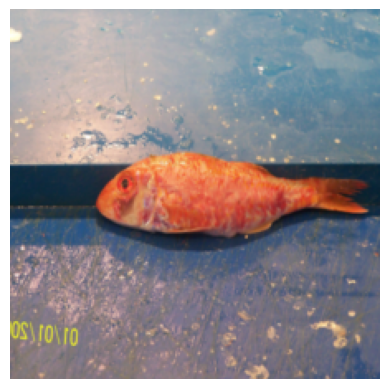

In [189]:
x_dec.show(ctx=plt)

In [190]:
cam_map.detach().cpu()

TensorImage([[0.0026, 0.0024, 0.0026,  ..., 0.0023, 0.0033, 0.0030],
             [0.0018, 0.0022, 0.0020,  ..., 0.0017, 0.0025, 0.0025],
             [0.0016, 0.0017, 0.0019,  ..., 0.0016, 0.0023, 0.0017],
             ...,
             [0.0024, 0.0020, 0.0018,  ..., 0.0030, 0.0028, 0.0017],
             [0.0020, 0.0020, 0.0016,  ..., 0.0030, 0.0037, 0.0033],
             [0.0020, 0.0019, 0.0020,  ..., 0.0025, 0.0035, 0.0032]])

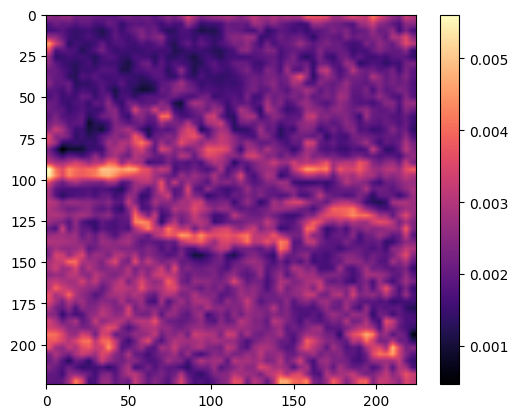

In [191]:
plt.imshow(
        cam_map.detach().cpu(),
        alpha=1,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
plt.colorbar()

In [134]:
test_cam_map = cam_map.detach().cpu()
test_im = x_dec

In [135]:
test_im[test_cam_map >= 0.004] = 0.0

IndexError: The shape of the mask [56, 56] at index 0 does not match the shape of the indexed tensor [3, 224, 224] at index 0

In [209]:
torch.Tensor(test_cam_map)

torch.Size([56, 56])

In [214]:
torch.unsqueeze(test_cam_map,0).shape

torch.Size([1, 56, 56])

In [223]:
import torchvision.transforms.functional as F

t_resized = F.resize(torch.unsqueeze(test_cam_map, 0), 224)
t_resized = torch.cat([t_resized, t_resized, t_resized], dim = 0)
t_resized.shape

torch.Size([3, 224, 224])

In [224]:
test_im.shape

torch.Size([3, 224, 224])

In [225]:
test_im[t_resized >= 0.004] = 0.0

<AxesSubplot:>

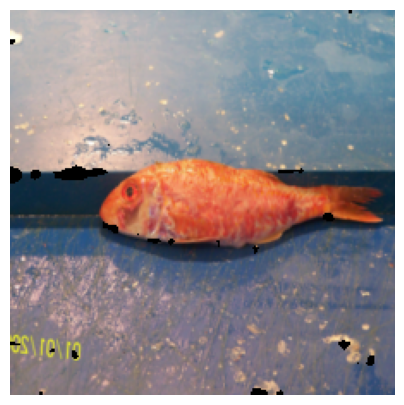

In [227]:
test_im.show()

In [232]:
learn.predict(test_im)

('Red Mullet',
 TensorBase(6),
 TensorBase([8.2614e-08, 1.6436e-07, 6.0089e-08, 1.4597e-07, 7.8244e-09,
             1.2217e-07, 9.9999e-01, 3.8425e-07, 7.8397e-09, 3.6929e-08,
             3.8507e-09, 1.8228e-07, 7.7231e-08, 4.6508e-07, 3.4131e-06,
             3.9664e-07, 8.1931e-08, 2.1415e-08]))

In [235]:
old_preds = np.array([3.3980e-07, 9.5405e-07, 2.6159e-06, 3.6172e-07, 3.4578e-08,
             1.6904e-07, 9.9963e-01, 1.4876e-06, 1.1928e-07, 1.2044e-06,
             1.6739e-07, 8.7124e-06, 1.2791e-06, 4.2001e-07, 3.5006e-04,
             2.5059e-06, 7.7516e-07, 2.5326e-07])
new_preds = np.array([8.2614e-08, 1.6436e-07, 6.0089e-08, 1.4597e-07, 7.8244e-09,
             1.2217e-07, 9.9999e-01, 3.8425e-07, 7.8397e-09, 3.6929e-08,
             3.8507e-09, 1.8228e-07, 7.7231e-08, 4.6508e-07, 3.4131e-06,
             3.9664e-07, 8.1931e-08, 2.1415e-08])

In [237]:
old_preds[6] , new_preds[6]

(0.99963, 0.99999)

In [242]:
old_preds[old_preds.argmin()] , new_preds[new_preds.argmin()]

(3.4578e-08, 3.8507e-09)

In [243]:
old_preds[old_preds.argmax()] , new_preds[new_preds.argmax()]

(0.99963, 0.99999)

In [38]:
preds, y = learn.get_preds()

In [39]:
bad_predictions = []
for i, (pred, gt_class) in enumerate(zip(preds, y)):
    pred_probability, predicted_class = torch.topk(pred, 1)
    is_correct = (predicted_class == gt_class)
    if is_correct:
        continue
    bad_predictions.append((i, predicted_class, pred_probability))

In [40]:
ds_idx, predicted_class, probability = bad_predictions[0]

In [51]:
img, label = dls.valid_ds[ds_idx]

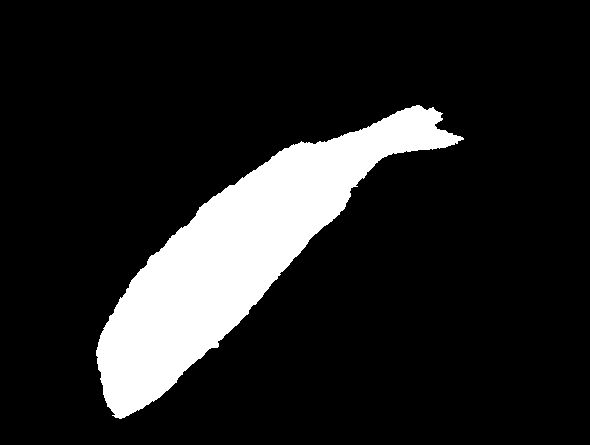

In [50]:
img

In [29]:
intp = ClassificationInterpretation.from_learner(learn)
intp.most_confused()

NameError: name 'cam_map' is not defined

<Figure size 1600x800 with 0 Axes>

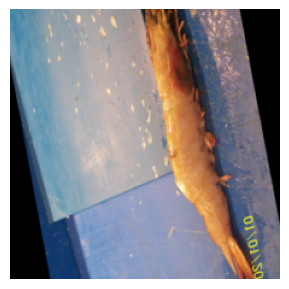

In [58]:
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00012.png"
)
(x,) = first(dls.test_dl([img]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[0][layer]) as hookg:  # for other layers
            with Hook(learn.model[0][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except:
        pass

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=0.8,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")

NameError: name 'cam_map' is not defined

<Figure size 1600x800 with 0 Axes>

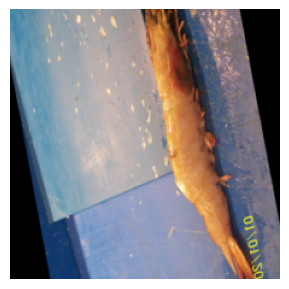

In [59]:
# ALL LAYERS CAM
img = PILImage.create(
    "/media/hdd/Datasets/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00012.png"
)
(x,) = first(dls.test_dl([img]))
# cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])

image_count = len(learn.model[0])
col = 4
row = math.ceil(image_count / col)
plt.figure(figsize=(col * 4, row * 4))
plt.figure(figsize=(col * 4, row * 4))

for layer in range(image_count):  # no of layers
    cls = 1
    try:
        with HookBwd(learn.model[0][layer]) as hookg:  # for other layers
            with Hook(learn.model[0][layer]) as hook:
                output = learn.model.eval()(x.cuda())
                act = hook.stored
            output[0, cls].backward()
            grad = hookg.stored
        w = grad[0].mean(dim=[1, 2], keepdim=True)
        cam_map = (w * act[0]).sum(0)

    except:
        pass

    plt.subplot(row, col, layer + 1)
    x_dec.show(ctx=plt)
    plt.imshow(
        cam_map.detach().cpu(),
        alpha=0.8,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="magma",
    )
    plt.title(f"Layer : {layer}")
    plt.axis("off")